In [23]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors 

%matplotlib widget

In [24]:
def GetDeltas(df_meta):
    filtered_df = df_meta[df_meta["label"].str.contains("Delta", na=False)]

    return filtered_df


def GetLargestDelta(df_meta):
    filtered_df = df_meta[df_meta["label"].str.contains("Delta", na=False)]

    # Get the max energy value per event
    max_energy_per_event = filtered_df.groupby("event_id")["energy"].transform("max")

    # Keep only rows where energy matches the max per event
    return filtered_df[filtered_df["energy"] == max_energy_per_event]

def GetBrems(df_meta):
    filtered_df = df_meta[df_meta["label"].str.contains("Brem", na=False)]

    return filtered_df

# Gets the sum of the primary track and the delta energies
def GetTrackDeltaEnergy(df_meta):
    # Filter events with brem in the name
    filtered_df = df_meta[ ~df_meta["label"].str.contains("Brem", na=False)]
    filtered_df =filtered_df[filtered_df.energy>0.01]
    trk_energies = filtered_df.groupby(["event_id"])["energy"].sum()
    return trk_energies.values


def FOM(eff, bkg_eff):
    return eff/np.sqrt(bkg_eff)

def CalcEfficiency(n, N, label):
    efficiency = n/N
    error=np.sqrt( (efficiency/N) * (1-efficiency)  )

    if (label == "Bkg"):
        print(f"Bkg Rej: {label}:", round(100*efficiency, 2), "+/-", round(100*error,2),  "%", "     (bkg rej ==", round(100-100*efficiency,2), "%)")
    else:
        print(f"Efficiency {label}:",  round(100*efficiency, 2), " +/-", round(100*error,2),  "%")

    return efficiency, error


# Cut out events with Brem in the name
def ApplyEventEnergyCut(df_meta, df_primary, E_res):

    event_energy = df_meta.groupby("event_id").energy.sum()

    if (E_res == 0.5):
        good_events = event_energy[(event_energy >= 2.454) & (event_energy <= 2.471)].index # 0.5%
    else:
        good_events = event_energy[(event_energy >= 2.433) & (event_energy <= 2.48)].index # 1.0%
    df_meta = df_meta[df_meta["event_id"].isin(good_events)]
    df_primary = df_primary[df_primary["event_id"].isin(good_events)]

    return df_meta, df_primary

# Function to compute count-based ratio per event_id
def compute_ratio(group):
    # Group 1: Count of Primary + Delta*
    count_group1 = group[group["label"].str.startswith(("Primary", "Delta"))].shape[0]

    # Group 2: Count of Brem* where 0.025 < energy < 0.035 (X-rays)
    count_xrays = group[(group["label"].str.startswith("Brem")) & (group["energy"].between(0.025, 0.035))].shape[0]

    # Group 3: Count of Brem* where energy ≤ 0.025 or ≥ 0.035
    count_group3 = group[(group["label"].str.startswith("Brem")) & (~group["energy"].between(0.025, 0.035))].shape[0]

    # Compute ratio
    ratio = count_xrays / (count_group1 + count_group3)
    
    return ratio

# applies cuts to the delta, brem and primary+delta energies
def ApplyGeneralCuts(df_meta, df_primary, cut_brem, cut_delta, cut_trk_e):

    brems  = GetBrems(df_meta)

    brems = brems[brems.energy > cut_brem] # these are events to cut

    df_meta = df_meta[~df_meta.event_id.isin(brems.event_id.unique())]
    df_primary = df_primary[~df_primary.event_id.isin(brems.event_id.unique())]

    deltas  = GetDeltas(df_meta)

    deltas = deltas[deltas.energy > cut_delta] # these are events to cut

    df_meta = df_meta[~df_meta.event_id.isin(deltas.event_id.unique())]
    df_primary = df_primary[~df_primary.event_id.isin(deltas.event_id.unique())]


    filtered_df = df_meta[ ~df_meta["label"].str.contains("Brem", na=False)]
    filtered_df =filtered_df[filtered_df.energy>0.01]
    trk_energies = filtered_df.groupby(["event_id"])["energy"].sum()
    trk_energies = trk_energies[trk_energies > cut_trk_e]
    unique_events_list = trk_energies.index.unique().tolist()

    df_meta = df_meta[~df_meta.event_id.isin(unique_events_list)]
    df_primary = df_primary[~df_primary.event_id.isin(unique_events_list)]

    return df_meta, df_primary

def ApplyDeltaLenCut(df_meta, df_primary, cut_delta):

    deltas  = GetDeltas(df_meta)

    deltas = deltas[deltas.length > cut_delta] # these are events to cut

    df_meta    = df_meta[~df_meta.event_id.isin(deltas.event_id.unique())]
    df_primary = df_primary[~df_primary.event_id.isin(deltas.event_id.unique())]

    return df_meta, df_primary

# Cut out events with Brem in the name
def ApplyNTracksLenCut(df_meta, df_primary, keep_xrays):

    brems  = GetBrems(df_meta)

    if (keep_xrays):
        brems = brems[ (brems.energy < 28e-3) & (brems.energy > 30e-3) ] # these are events to cut

    df_meta    = df_meta[~df_meta.event_id.isin(brems.event_id.unique())]
    df_primary = df_primary[~df_primary.event_id.isin(brems.event_id.unique())]

    return df_meta, df_primary

def ApplyCuts(df_meta, df_primary, pressure, diffusion, mode, Eres):

    cuts = []

    # Apply containment
    df_meta = df_meta[df_meta.contained == True]
    df_primary = df_primary[df_primary.contained == True]
    df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)

    # 1 bar
    if (pressure == 1):
       
        # 1bar no diff
        if (diffusion == "nodiff"):
            
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.4) & (df_primary.blob1R > 0.4) & (df_primary.blob2 > 0.4) & (df_primary.Tortuosity2 > 1.7) & (df_primary.energy > 1.95) & (df_primary.Squiglicity2 > 2)
            
            elif (mode == "nat"):
                cuts = (df_primary.blob2R > 0.4) & (df_primary.blob1R > 0.4) & (df_primary.blob2 > 0.4) & (df_primary.Tortuosity2 > 1.7) & (df_primary.energy > 2.18) & (df_primary.Squiglicity2 > 2)

            else:
                print("Unknown cut mode specified")
        # -------------------------------------------------------------------------------------------------------------------------------------
        # 1bar 5%
        elif (diffusion == "5percent"):
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.37) & (df_primary.blob1R > 0.34) &  (df_primary.energy > 2.35) & (df_primary.Tortuosity2 >1.3)

            elif (mode == "simple"):
                df_meta, df_primary = ApplyNTracksLenCut(df_meta, df_primary, keep_xrays=True)
                cuts = (df_primary.blob2R > 0.3) 

            elif (mode == "nat"):
                cuts = (df_primary.blob2R > 0.44) & (df_primary.blob2 > 0.45) & (df_primary.blob1R > 0.34) &  (df_primary.energy > 2.35) & (df_primary.Tortuosity2 >1.3)

            else:
                print("Unknown cut mode specified")
        # -------------------------------------------------------------------------------------------------------------------------------------
        # 1bar 0.25%
        elif (diffusion == "0.25percent"):
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.38) & (df_primary.blob2 > 0.35) & (df_primary.blob1R > 0.3)  & (df_primary.energy > 2.39)

            elif (mode == "nat"):
                cuts = (df_primary.blob2R > 0.45) & (df_primary.blob2 > 0.45) & (df_primary.blob1R > 0.3)  & (df_primary.energy > 2.38)

            else:
                print("Unknown cut mode specified")
        # -------------------------------------------------------------------------------------------------------------------------------------
        # 1bar 0.1%
        elif (diffusion == "0.1percent"):
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.385) & (df_primary.blob2 > 0.3)     & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.4) & (df_primary.length > 1000)

            elif (mode == "nat"):
                cuts = (df_primary.blob2R > 0.44) & (df_primary.blob2 > 0.45)     & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.4) & (df_primary.length > 1000)
            else:
                print("Unknown cut mode specified")
        # -------------------------------------------------------------------------------------------------------------------------------------
        # 1bar 10 He%
        elif (diffusion == "0.05percent"):
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.33) & (df_primary.blob2 > 0.3)     & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.4) & (df_primary.length > 600)

            elif (mode == "nat"):
                cuts = (df_primary.blob2R > 0.43) & (df_primary.blob2 > 0.43)     & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.4) & (df_primary.length > 600)

            else:
                print("Unknown cut mode specified")
        # -------------------------------------------------------------------------------------------------------------------------------------
        # 1bar 0.0%
        elif (diffusion == "0.0percent"):
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2 > 0.18) & (df_primary.blob2R > 0.18) &  (df_primary.energy > 2.33) & (df_primary.length > 600)

            elif (mode == "nat"):
                cuts = (df_primary.blob2 > 0.25) & (df_primary.blob2R > 0.25) &  (df_primary.blob1 > 0.18) &  (df_primary.energy > 2.4) & (df_primary.length > 600)

            else:
                print("Unknown cut mode specified")

        else:
            print("Unknown diffusion specified")
    # -------------------------------------------------------------------------------------------------------------------------------------
    # 5bar
    elif (pressure == 5):
    
        # 5 bar no diff
        if (diffusion == "nodiff"):
            
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.42) & (df_primary.blob2 > 0.42) & (df_primary.blob1 > 0.42) & (df_primary.blob1R > 0.42) & (df_primary.energy > 2.35) & (df_primary.energy < 2.5)  & (df_primary.Tortuosity2 > 1.36)

            elif (mode == "nat"):
                cuts = (df_primary.blob2R > 0.45) & (df_primary.blob2 > 0.45) & (df_primary.blob1 > 0.42) & (df_primary.blob1R > 0.42) & (df_primary.energy > 2.35) & (df_primary.energy < 2.5)  & (df_primary.Tortuosity2 > 1.36)
                
            else:
                print("Unknown efficiency target specified")
        # -------------------------------------------------------------------------------------------------------------------------------------
        # 5bar 5%
        elif (diffusion == "5percent"):
            
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.35) & (df_primary.blob1R > 0.35) & (df_primary.energy > 2.4) & (df_primary.Tortuosity2 > 1.3)
            
            elif (mode == "simple"):
                df_meta, df_primary = ApplyNTracksLenCut(df_meta, df_primary, keep_xrays=False)
                cuts = (df_primary.blob2R > 0.3) & (df_primary.blob2 > 0.4) 

            elif (mode == "nat"):
                cuts = (df_primary.blob2R > 0.4) &  (df_primary.blob2 > 0.39) & (df_primary.blob1R > 0.35) & (df_primary.energy > 2.4) & (df_primary.Tortuosity2 > 1.3)

            else:
                print("Unknown cut mode specified")

        # 5bar 10% He
        elif (diffusion == "0.05percent"):
            
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2 > 0.65) & (df_primary.energy > 2.35)
            elif (mode == "nat"):
                cuts = (df_primary.blob2 > 0.67) & (df_primary.blob1 > 0.67) & (df_primary.energy > 2.36)
            else:
                print("Unknown cut mode specified")

        else:
            print("Unknown diffusion specified")

    # -------------------------------------------------------------------------------------------------------------------------------------
    # 10bar
    elif (pressure == 10):

        # 10bar no diff
        if (diffusion == "nodiff"):
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.4) & (df_primary.blob2 > 0.59) & (df_primary.blob1 > 0.4) & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.35) & (df_primary.energy < 2.5) 
            elif (mode == "nat"):
                cuts = (df_primary.blob2R > 0.45) & (df_primary.blob2 > 0.59) & (df_primary.blob1 > 0.5) & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.35) & (df_primary.energy < 2.5) 
            else:
                print("Unknown cut mode specified")

        # -------------------------------------------------------------------------------------------------------------------------------------
        # 10bar 5%
        elif (diffusion == "5percent"):
            
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.42) & (df_primary.blob2 > 0.4) & (df_primary.blob1R > 0.42) & (df_primary.energy > 2.4) 

            elif (mode == "simple"):
                df_meta, df_primary = ApplyNTracksLenCut(df_meta, df_primary, keep_xrays=False)
                cuts = (df_primary.blob2R > 0.3) & (df_primary.blob2 > 0.4) 

            elif (mode == "nat"):
                cuts = (df_primary.blob2R > 0.45) & (df_primary.blob2 > 0.45) & (df_primary.blob2 > 0.4) & (df_primary.blob1R > 0.42) & (df_primary.energy > 2.4) 

            else:
                print("Unknown cut mode specified")

        # 10bar 10% He
        elif (diffusion == "0.05percent"):
            
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.27) & (df_primary.blob2 > 0.27) & (df_primary.energy > 2.2) 

            elif (mode == "nat"):
                cuts = (df_primary.blob2R > 0.3) & (df_primary.blob2 > 0.3) & (df_primary.energy > 2.2) 

            else:
                print("Unknown cut mode specified")

        else:
            print("Unknown diffusion specified")

    # -------------------------------------------------------------------------------------------------------------------------------------
    # 15bar
    elif (pressure == 15):
        
        # 15bar no diff
        if (diffusion == "nodiff"):
        
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.52) & (df_primary.blob2 > 0.52) & (df_primary.blob1 > 0.39) & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.35) & (df_primary.energy < 2.5)
            
            elif (mode == "nat"):
                cuts = (df_primary.blob2R > 0.53) & (df_primary.blob2 > 0.58) & (df_primary.blob1 > 0.39) & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.35) & (df_primary.energy < 2.5)

            else:
                print("Unknown cut mode specified")

        # -------------------------------------------------------------------------------------------------------------------------------------
        # 15bar 5%
        elif (diffusion == "5percent"):
            
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.53) & (df_primary.blob2 > 0.6) & (df_primary.blob1 > 0.4) & (df_primary.energy > 2.35)


            elif (mode == "simple"):
                df_meta, df_primary = ApplyNTracksLenCut(df_meta, df_primary, keep_xrays=False)
                cuts = (df_primary.blob2R > 0.25) & (df_primary.blob2 > 0.35) 

            elif (mode == "nat"):
                cuts = (df_primary.blob2R > 0.53) & (df_primary.blob2 > 0.7) & (df_primary.blob1 > 0.4) & (df_primary.energy > 2.35)

            else:
                print("Unknown cut mode specified")
        # -------------------------------------------------------------------------------------------------------------------------------------
        # 15bar 10% he
        elif (diffusion == "0.05percent"):
            
            # All cuts
            if (mode == "all"):
                cuts =  (df_primary.blob2 > 0.64) & (df_primary.energy > 2.35)
            elif (mode == "nat"):
                cuts =  (df_primary.blob2 > 0.67) & (df_primary.energy > 2.35)

            else:
                print("Unknown cut mode specified")

        else:
            print("Unknown diffusion specified")

    # -------------------------------------------------------------------------------------------------------------------------------------
    # 25bar
    elif (pressure == 25):

        # 25bar no diff
        if (diffusion == "nodiff"):
        
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.56) & (df_primary.blob2 > 0.56) & (df_primary.blob1 > 0.39) & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.35) & (df_primary.energy < 2.5)

            elif (mode == "nat"):
                cuts = (df_primary.blob2R > 0.57) & (df_primary.blob2 > 0.57) & (df_primary.blob1 > 0.39) & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.35) & (df_primary.energy < 2.5)

            else:
                print("Unknown cut mode specified")

        # -------------------------------------------------------------------------------------------------------------------------------------
        # 25bar 5%
        elif (diffusion == "5percent"):
            
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.43) & (df_primary.blob2 > 0.43) & (df_primary.blob1 > 0.3) & (df_primary.energy > 2.4) 
        
            elif (mode == "simple"):
                df_meta, df_primary = ApplyNTracksLenCut(df_meta, df_primary, keep_xrays=False)
                cuts = (df_primary.blob2R > 0.25) & (df_primary.blob2 > 0.35) 

            elif (mode == "nat"):
                cuts = (df_primary.blob2R > 0.45) & (df_primary.blob2 > 0.45) & (df_primary.blob1 > 0.3) & (df_primary.energy > 2.4) 

            else:
                print("Unknown cut mode specified")
        # -------------------------------------------------------------------------------------------------------------------------------------
        # 25bar 10% He
        elif (diffusion == "0.05percent"):
            
            # All cuts
            if (mode == "all"):
                cuts = (df_primary.blob2R > 0.43) & (df_primary.blob2 > 0.43) & (df_primary.blob1 > 0.3) & (df_primary.energy > 2.4) 

        else:
            print("Unknown diffusion specified")

    else:
        print("Unknown pressure specified")

    return df_meta, df_primary, cuts

In [25]:
diff="5percent"


nubb_meta_1bar  = pd.read_hdf(f"../data/Trackreco/ATPC_0nubb_1bar_{diff}_reco.h5",  "meta")
nubb_meta_5bar  = pd.read_hdf(f"../data/Trackreco/ATPC_0nubb_5bar_{diff}_reco.h5",  "meta")
nubb_meta_10bar = pd.read_hdf(f"../data/Trackreco/ATPC_0nubb_10bar_{diff}_reco.h5", "meta")
nubb_meta_15bar = pd.read_hdf(f"../data/Trackreco/ATPC_0nubb_15bar_{diff}_reco.h5", "meta")
# display(nubb_meta_1bar)

Tl_meta_1bar  = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_ion_1bar_{diff}_reco.h5",  "meta")
Tl_meta_5bar  = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_ion_5bar_{diff}_reco.h5",  "meta")
Tl_meta_10bar = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_ion_10bar_{diff}_reco.h5", "meta")
Tl_meta_15bar = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_ion_15bar_{diff}_reco.h5", "meta")
# display(Tl_meta_1bar)

Bi_meta_1bar  = pd.read_hdf(f"../data/Trackreco/ATPC_Bi_ion_1bar_{diff}_reco.h5",  "meta")
Bi_meta_5bar  = pd.read_hdf(f"../data/Trackreco/ATPC_Bi_ion_5bar_{diff}_reco.h5",  "meta")
Bi_meta_10bar = pd.read_hdf(f"../data/Trackreco/ATPC_Bi_ion_10bar_{diff}_reco.h5", "meta")
Bi_meta_15bar = pd.read_hdf(f"../data/Trackreco/ATPC_Bi_ion_15bar_{diff}_reco.h5", "meta")
# display(Bi_meta_1bar)

single_meta_1bar  = pd.read_hdf(f"../data/Trackreco/ATPC_single_1bar_{diff}_reco.h5",  "meta")
single_meta_5bar  = pd.read_hdf(f"../data/Trackreco/ATPC_single_5bar_{diff}_reco.h5",  "meta")
single_meta_10bar = pd.read_hdf(f"../data/Trackreco/ATPC_single_10bar_{diff}_reco.h5", "meta")
single_meta_15bar = pd.read_hdf(f"../data/Trackreco/ATPC_single_15bar_{diff}_reco.h5", "meta")

Bkg_meta_1bar  = pd.concat([Tl_meta_1bar,  Bi_meta_1bar,  single_meta_1bar])
Bkg_meta_5bar  = pd.concat([Tl_meta_5bar,  Bi_meta_5bar,  single_meta_5bar])
Bkg_meta_10bar = pd.concat([Tl_meta_10bar, Bi_meta_10bar, single_meta_10bar])
Bkg_meta_15bar = pd.concat([Tl_meta_15bar, Bi_meta_15bar, single_meta_15bar])


# True tables
nubb_nexus_true     = pd.read_hdf("../data/TrueInfo/TrueInfo_ATPC_0nubb.h5", "trueinfo")
Bi_nexus_true       = pd.read_hdf("../data/TrueInfo/TrueInfo_ATPC_Bi_ion.h5", "trueinfo")
Tl_nexus_true       = pd.read_hdf("../data/TrueInfo/TrueInfo_ATPC_Tl_ion.h5", "trueinfo")
single_nexus_true   = pd.read_hdf("../data/TrueInfo/TrueInfo_ATPC_single.h5", "trueinfo")

Bkg_nexus_true  = pd.concat([Tl_nexus_true,  Bi_nexus_true, single_nexus_true])

display(nubb_nexus_true)

display(nubb_meta_1bar)

if (diff == "nodiff"):
    diff = "smear"
elif (diff == "5percent"):
    diff = "5% CO2"
elif (diff == "0.25percent"):
    diff = "0.25% CO2"
elif (diff == "0.1percent"):
    diff = "0.1% CO2"


,event_id,TrackLength,TrackEnergy,TrackEnergy1,TrackEnergy2,TrackEnergy3,Blob1E,Blob2E,TrackDiam,CreatorProc,pressure
0,122,4216.897949,2.399602,2.399602,2.399602,2.399602,0.423130,0.329951,1743.526611,DBD,1
1,123,2268.957275,2.417973,1.627562,1.627562,1.627562,0.859682,0.789868,515.006165,DBD,1
2,124,3010.137695,2.275174,1.969749,2.275174,2.275174,0.706038,0.598835,1614.624512,DBD,1
3,126,4089.244141,2.385394,2.385394,2.385394,2.385394,0.583413,0.531469,1026.841309,DBD,1
4,127,3113.080322,2.451339,2.054533,2.156931,2.451339,0.876109,0.606319,1243.513184,DBD,1
...,...,...,...,...,...,...,...,...,...,...,...
61,74064,125.202499,2.349006,2.349006,2.349006,2.349006,0.722298,0.562367,47.934620,DBD,25
62,74065,104.653709,1.915351,1.915351,1.915351,1.915351,0.752928,0.476526,34.527061,DBD,25
63,74066,116.408737,2.452040,2.314679,2.452040,2.452040,1.108506,0.783051,28.364790,DBD,25
64,74067,120.777702,2.393655,2.393655,2.393655,2.393655,0.698741,0.632156,44.764549,DBD,25


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label,contained
0,122,0,1,58,0,3903.420,2.442542,0.534247,0.463019,0.440886,0.343871,1.779691,1.311387,1.129758,0.640742,Primary,True
0,122,1,0,40,40,0.000,0.022603,0.022603,0.022603,0.022603,0.022603,0.000000,0.000000,0.000000,0.000000,Brem,True
0,123,0,1,3,30,2222.375,1.883875,0.632472,0.353294,0.486125,0.486926,2.072101,1.212093,1.292563,0.620306,Primary,True
0,123,1,0,62,94,479.496,0.553575,0.553575,0.553575,0.000000,0.553575,1.198429,1.629930,0.327844,0.764449,Delta0,True
0,123,2,0,97,97,0.000,0.031812,0.031812,0.031812,0.031812,0.031812,0.000000,0.000000,0.000000,0.000000,Brem,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1280,0,1,73,19,2601.658,2.468939,0.632025,0.442064,0.494735,0.895118,1.628080,1.341874,0.910127,0.503079,Primary,True
0,1281,0,1,110,57,3194.388,2.409687,0.565059,0.511468,0.594929,0.902864,2.126372,1.753607,1.460183,0.913130,Primary,True
0,1281,1,0,27,27,0.000,0.032751,0.032751,0.032751,0.032751,0.032751,0.000000,0.000000,0.000000,0.000000,Brem,True
0,1281,2,0,38,38,0.000,0.023772,0.023772,0.023772,0.023772,0.023772,0.000000,0.000000,0.000000,0.000000,Brem,True


In [26]:
plt.rcParams.update({'font.size': 12})
def PlotTrueDists(df, col, label, pressure, diff):

    uselog = False

    df = df[df.pressure == pressure]

    axs[0,0].hist(df.TrackLength*pressure, bins = np.linspace(0, 5000, 100), histtype="step", color = col, label = label);
    axs[0,0].set_xlabel("Primary Track Length * P [mm bar]")
    axs[0,0].set_ylabel("Entries")
    axs[0,0].legend()
    # axs[0,0].set_title(f"{diff}")
    if (uselog): axs[0,0].semilogy()

    axs[0,1].hist(df.TrackEnergy, bins = np.linspace(0,3,100), histtype="step", color = col, label = label);
    axs[0,1].set_xlabel("Primary Track Energy [MeV]")
    axs[0,1].set_ylabel("Entries")
    axs[0,1].legend()
    # axs[0,1].set_title(f"{diff}")
    if (uselog): axs[0,1].semilogy()

    axs[0,2].hist(df.Blob1E, bins = np.linspace(0, 1.25, 100), histtype="step", color = col, label = label);
    axs[0,2].set_xlabel("Blob 1 energy [MeV]")
    axs[0,2].set_ylabel("Entries")
    axs[0,2].legend()
    # axs[0,2].set_title(f"{diff}")
    if (uselog): axs[0,2].semilogy()

    axs[1,0].hist(df.Blob2E, bins = np.linspace(0, 1, 100), histtype="step", color = col, label = label);
    axs[1,0].set_xlabel("Blob 2 energy [MeV]")
    axs[1,0].set_ylabel("Entries")
    axs[1,0].legend()
    # axs[1,0].set_title(f"{diff}")
    if (uselog): axs[1,0].semilogy()

    axs[1,1].hist(df.TrackDiam*pressure, bins = np.linspace(0, 3000, 100), histtype="step", color = col, label = label);
    axs[1,1].set_xlabel("Primary Track Diameter * P [mm bar]")
    axs[1,1].set_ylabel("Entries")
    axs[1,1].legend()
    # axs[1,1].set_title(f"{diff}")
    if (uselog): axs[1,1].semilogy()

    plt.tight_layout()

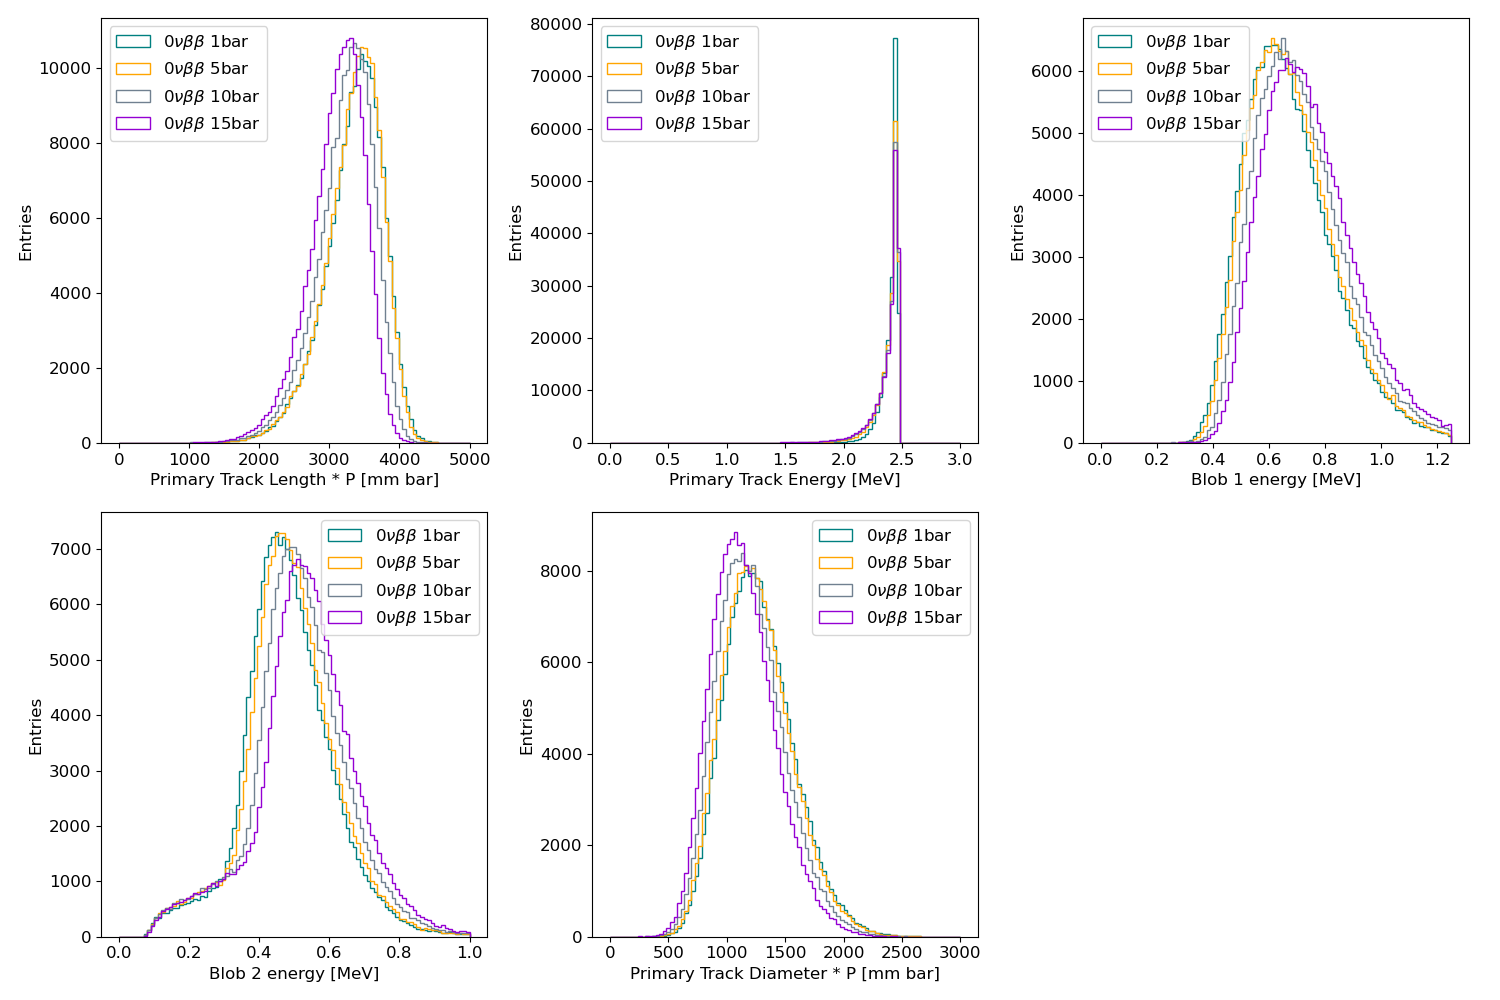

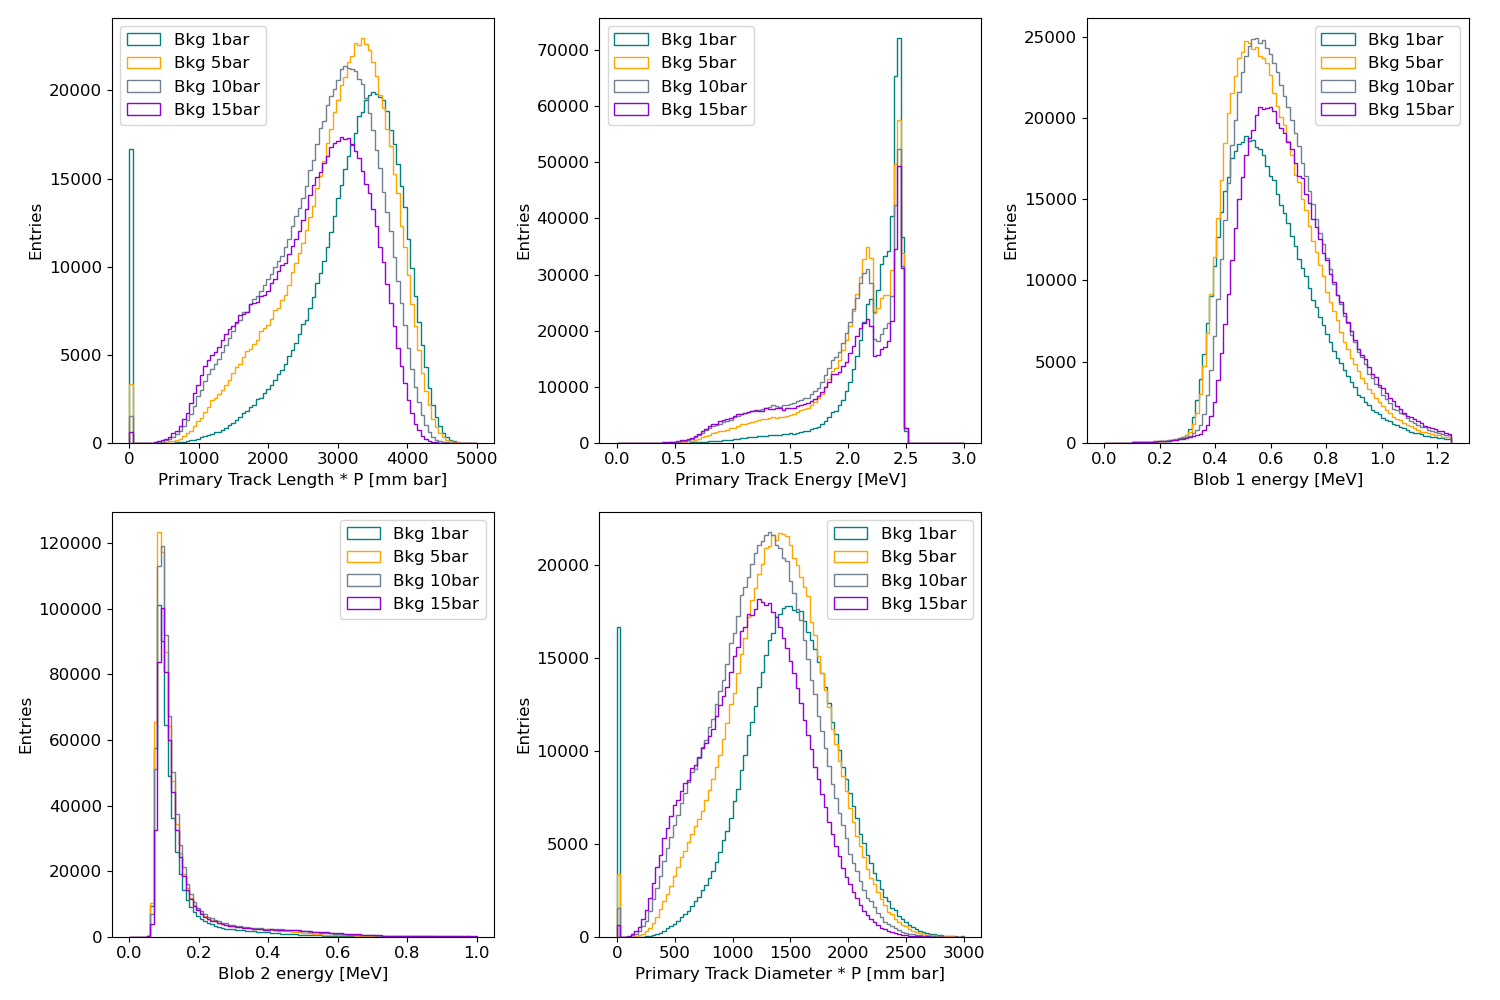

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

PlotTrueDists(nubb_nexus_true, "Teal",        r"$0\nu\beta\beta$ 1bar",  1, diff)
PlotTrueDists(nubb_nexus_true, "orange",      r"$0\nu\beta\beta$ 5bar",  5, diff)
PlotTrueDists(nubb_nexus_true, "slategray",   r"$0\nu\beta\beta$ 10bar", 10, diff)
PlotTrueDists(nubb_nexus_true, "darkviolet",  r"$0\nu\beta\beta$ 15bar", 15, diff)
axs[1,2].axis('off')
plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/TrueDistributionsSignal.pdf")

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
PlotTrueDists(Bkg_nexus_true, "Teal",       "Bkg 1bar",  1, diff)
PlotTrueDists(Bkg_nexus_true, "orange",     "Bkg 5bar",  5, diff)
PlotTrueDists(Bkg_nexus_true, "slategray",  "Bkg 10bar", 10, diff)
PlotTrueDists(Bkg_nexus_true, "darkviolet", "Bkg 15bar", 15, diff)
axs[1,2].axis('off')
plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/TrueDistributionsBackground.pdf")


In [44]:
def Plot2Dhist(ax, varx, vary, bins):

    hist, xedges, yedges = np.histogram2d(varx, vary, bins=bins)

    # 2. Mask zero bins
    masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

    # 3. Create a custom colormap with white for the masked values (zero bins)
    cmap = plt.cm.viridis  # Choose a colormap you like
    cmap.set_bad(color='white')  # Set masked values (zeros) to white

    # 4. Plot the 2D histogram
    pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap, norm=mcolors.LogNorm())

    # # Add color bar
    # plt.colorbar(pcm, ax=ax, label='Counts')


def PlotTrueRecoDists(df_true, df_reco, label, pressure, diff):

    uselog = True

    df_true = df_true[df_true.pressure == pressure]
    df_reco = df_reco[df_reco.primary == 1]

    # Ensure the reco and true have the same events
    df_true = df_true[df_true.event_id.isin(df_reco.event_id.unique())]
    df_reco = df_reco[df_reco.event_id.isin(df_true.event_id.unique())]

    df = pd.merge(df_true, df_reco, on='event_id', how='inner')

    Plot2Dhist(axs[0], df.TrackLength, df.length, bins = [np.linspace(0, 5000/pressure, 100), np.linspace(0, 5000/pressure, 100)])
    axs[0].set_xlabel("True Primary Track Length [mm]")
    axs[0].set_ylabel("Reco Primary Track Length [mm]")
    axs[0].set_title(f"{label} {pressure}bar {diff}")

    Plot2Dhist(axs[1], df.TrackEnergy, df.energy, bins = [np.linspace(0,3,100), np.linspace(0,3,100)])
    axs[1].set_xlabel("True Primary Track Energy [MeV]")
    axs[1].set_ylabel("Reco Primary Track Energy [MeV]")
    axs[1].set_title(f"{label} {pressure}bar {diff}")

    Plot2Dhist(axs[2], df.Blob1E, df.blob1R, bins = [np.linspace(0, 1.25, 100), np.linspace(0, 1.25, 100)])
    axs[2].set_xlabel("True Blob 1 energy [MeV]")
    axs[2].set_ylabel("Reco Blob 1 energy [MeV]")
    axs[2].set_title(f"{label} {pressure}bar {diff}")

    Plot2Dhist(axs[3], df.Blob2E, df.blob2R, bins = [np.linspace(0, 1, 100), np.linspace(0, 1, 100)])
    axs[3].set_xlabel("True Blob 2 energy [MeV]")
    axs[3].set_ylabel("Reco Blob 2 energy [MeV]")
    axs[3].set_title(f"{label} {pressure}bar {diff}")

    plt.tight_layout()

In [45]:
# Decide to apply cuts

ApplyCutsb = False


def Selection(df_meta, pressure, diffusion, mode, eres):

    df_primary = df_meta[ (df_meta.label == "Primary") & (df_meta.primary == 1)]

    # Apply the cuts
    df_meta, df_primary, cuts = ApplyCuts(df_meta, df_primary, pressure, diffusion, mode, eres)
    
    df_primary = df_primary[ cuts ]

    df_meta = df_meta[(df_meta.event_id.isin(df_primary.event_id.unique()))]


    return df_meta

if (ApplyCutsb):
    nubb_meta_1bar = Selection(nubb_meta_1bar, 1, "5percent", "all", 0.5)
    nubb_nexus_true_1bar = nubb_nexus_true[nubb_nexus_true.pressure == 1]
    nubb_nexus_true_1bar = nubb_nexus_true_1bar[(nubb_nexus_true_1bar.event_id.isin(nubb_meta_1bar.event_id.unique()))] 

    nubb_meta_5bar = Selection(nubb_meta_5bar, 5, "5percent", "all", 0.5)
    nubb_nexus_true_5bar = nubb_nexus_true[nubb_nexus_true.pressure == 5]
    nubb_nexus_true_5bar = nubb_nexus_true_5bar[(nubb_nexus_true_5bar.event_id.isin(nubb_meta_5bar.event_id.unique()))] 

    nubb_meta_10bar = Selection(nubb_meta_10bar, 10, "5percent", "all", 0.5)
    nubb_nexus_true_10bar = nubb_nexus_true[nubb_nexus_true.pressure == 10]
    nubb_nexus_true_10bar = nubb_nexus_true_10bar[(nubb_nexus_true_10bar.event_id.isin(nubb_meta_10bar.event_id.unique()))] 

    nubb_meta_15bar = Selection(nubb_meta_15bar, 15, "5percent", "all", 0.5)
    nubb_nexus_true_15bar = nubb_nexus_true[nubb_nexus_true.pressure == 15]
    nubb_nexus_true_15bar = nubb_nexus_true_15bar[(nubb_nexus_true_15bar.event_id.isin(nubb_meta_15bar.event_id.unique()))] 


    Bkg_meta_1bar = Selection(Bkg_meta_1bar, 1, "5percent", "all", 0.5)
    Bkg_nexus_true_1bar = Bkg_nexus_true[Bkg_nexus_true.pressure == 1]
    Bkg_nexus_true_1bar = Bkg_nexus_true_1bar[(Bkg_nexus_true_1bar.event_id.isin(Bkg_meta_1bar.event_id.unique()))] 

    Bkg_meta_5bar = Selection(Bkg_meta_5bar, 5, "5percent", "all", 0.5)
    Bkg_nexus_true_5bar = Bkg_nexus_true[Bkg_nexus_true.pressure == 5]
    Bkg_nexus_true_5bar = Bkg_nexus_true_5bar[(Bkg_nexus_true_5bar.event_id.isin(Bkg_meta_5bar.event_id.unique()))] 

    Bkg_meta_10bar = Selection(Bkg_meta_10bar, 10, "5percent", "all", 0.5)
    Bkg_nexus_true_10bar = Bkg_nexus_true[Bkg_nexus_true.pressure == 10]
    Bkg_nexus_true_10bar = Bkg_nexus_true_10bar[(Bkg_nexus_true_10bar.event_id.isin(Bkg_meta_10bar.event_id.unique()))] 

    Bkg_meta_15bar = Selection(Bkg_meta_15bar, 15, "5percent", "all", 0.5)
    Bkg_nexus_true_15bar = Bkg_nexus_true[Bkg_nexus_true.pressure == 15]
    Bkg_nexus_true_15bar = Bkg_nexus_true_15bar[(Bkg_nexus_true_15bar.event_id.isin(Bkg_meta_15bar.event_id.unique()))] 


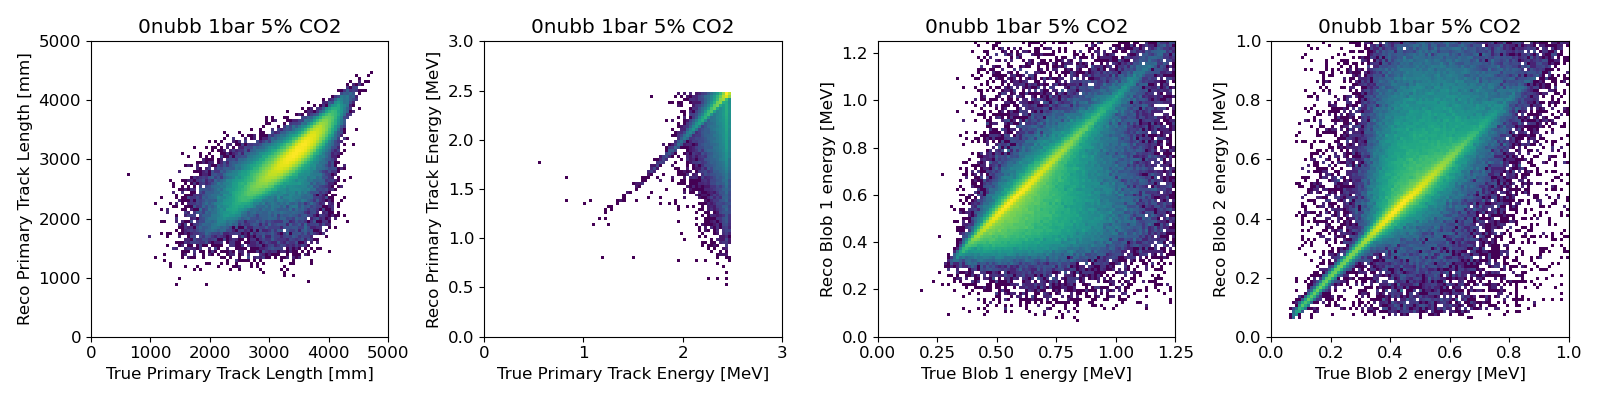

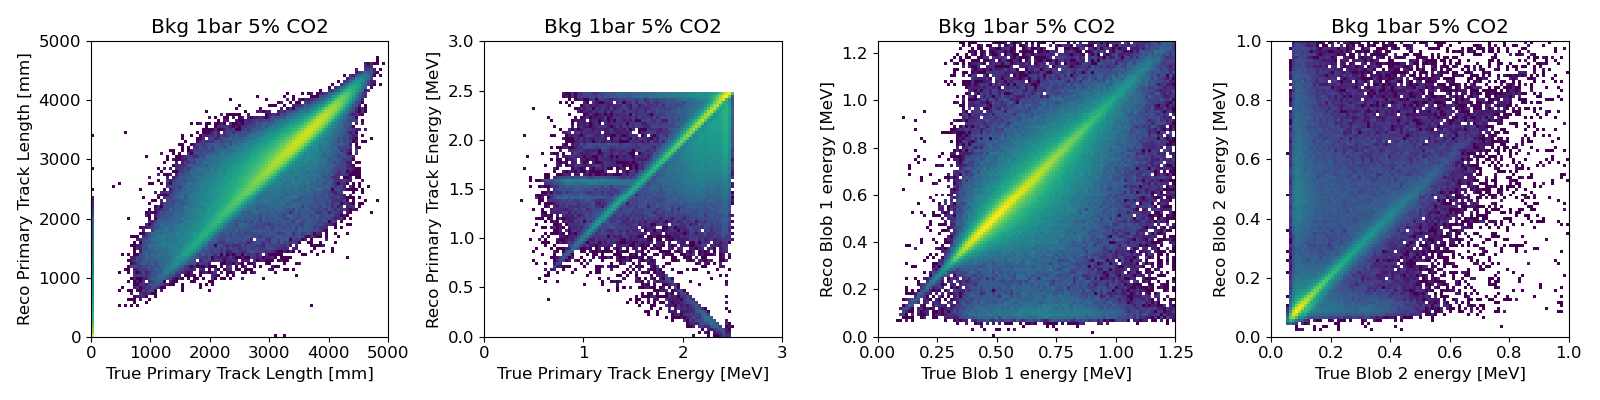

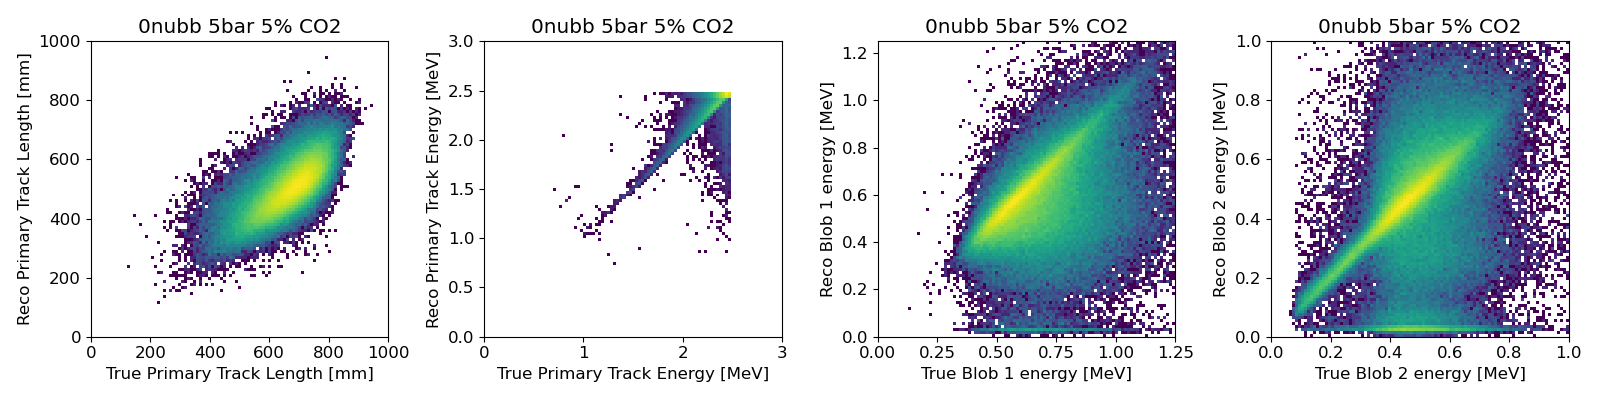

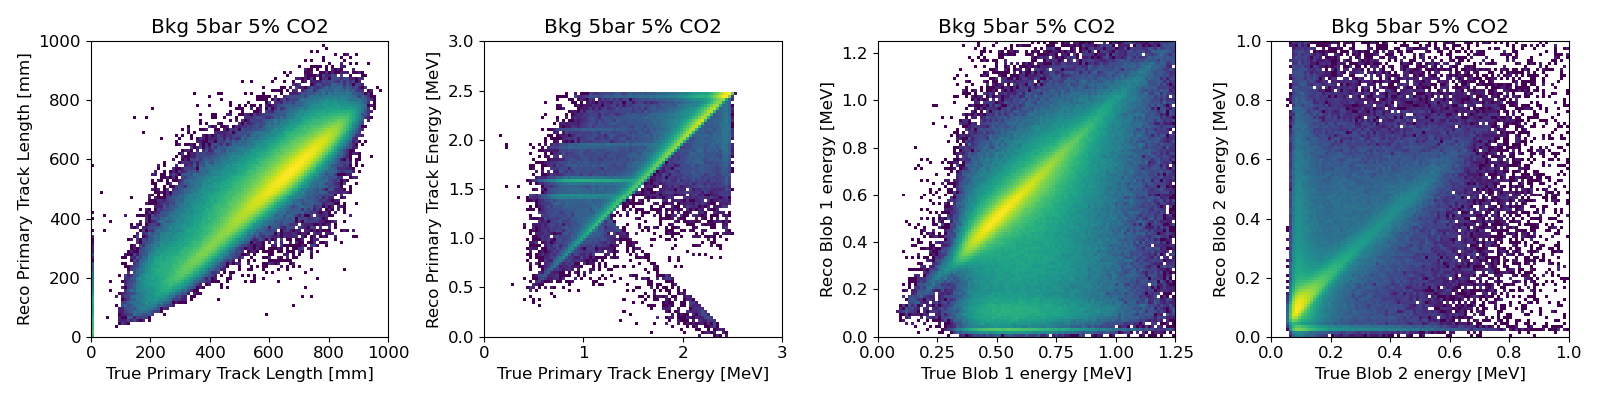

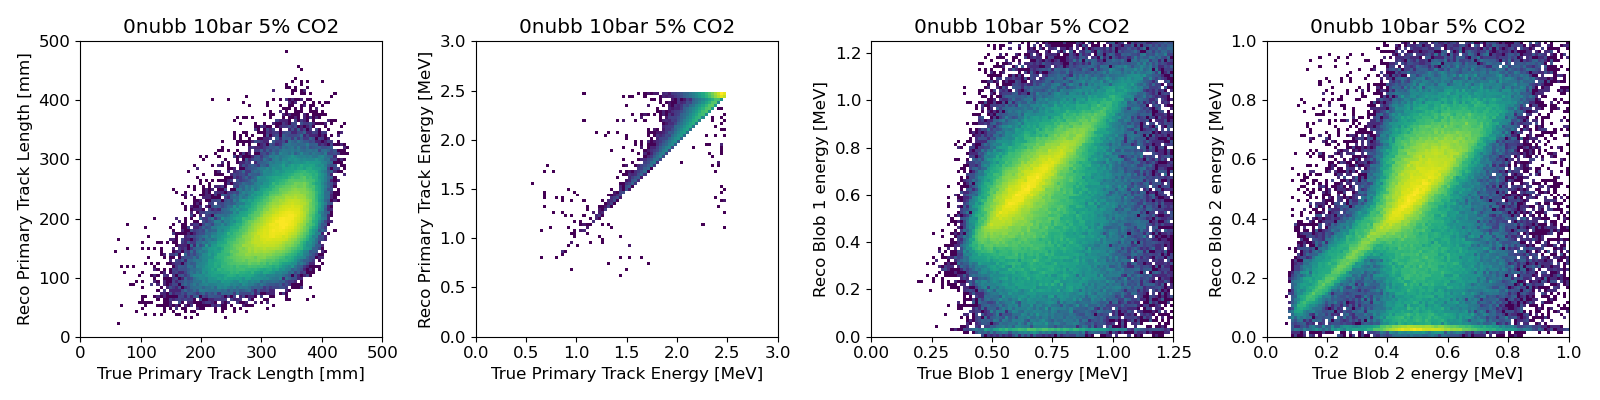

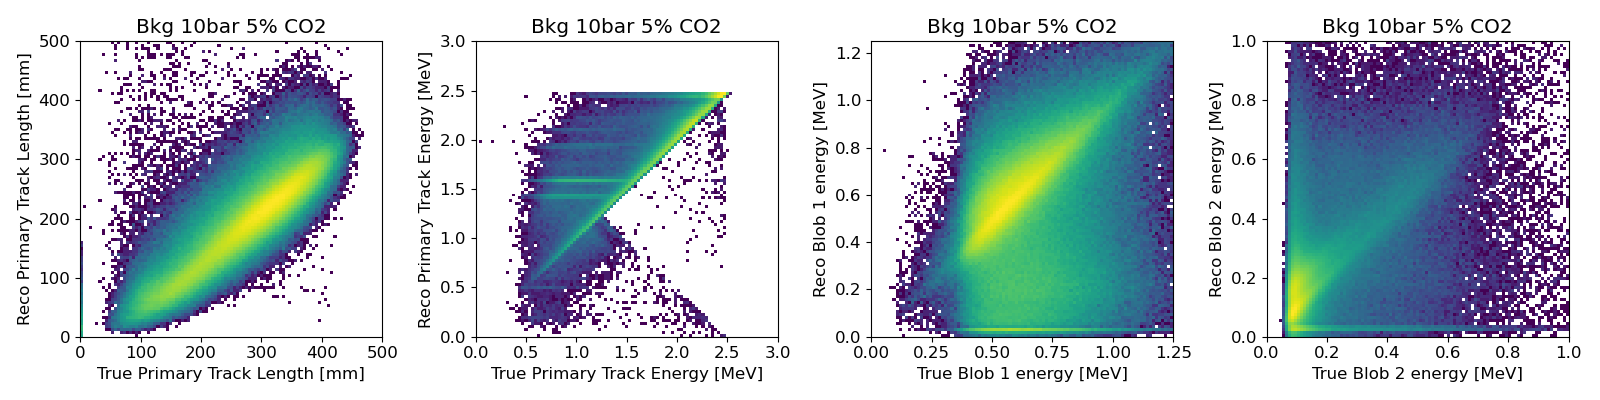

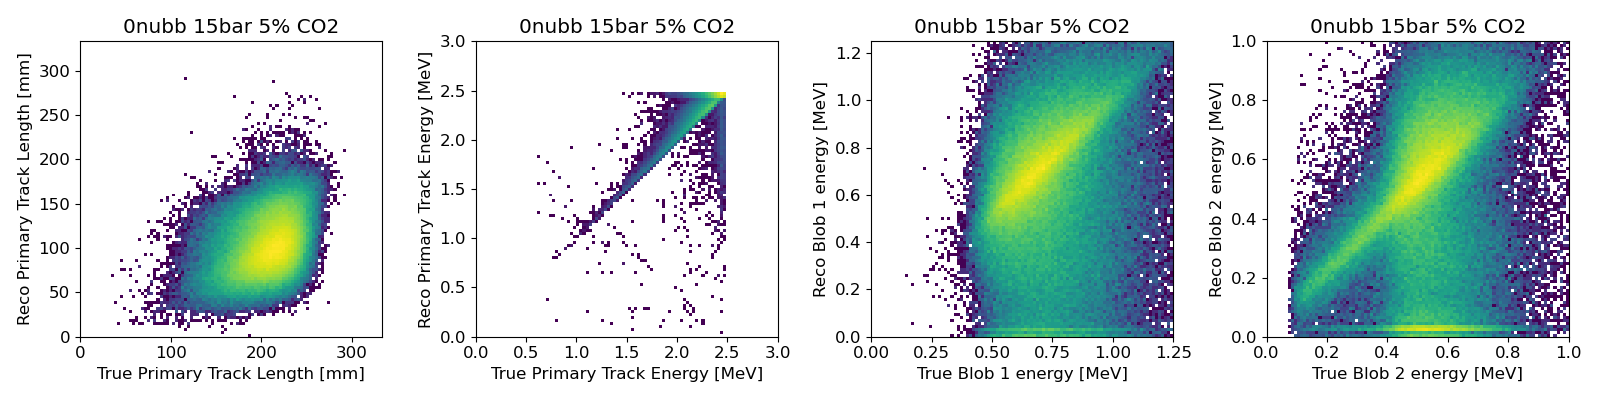

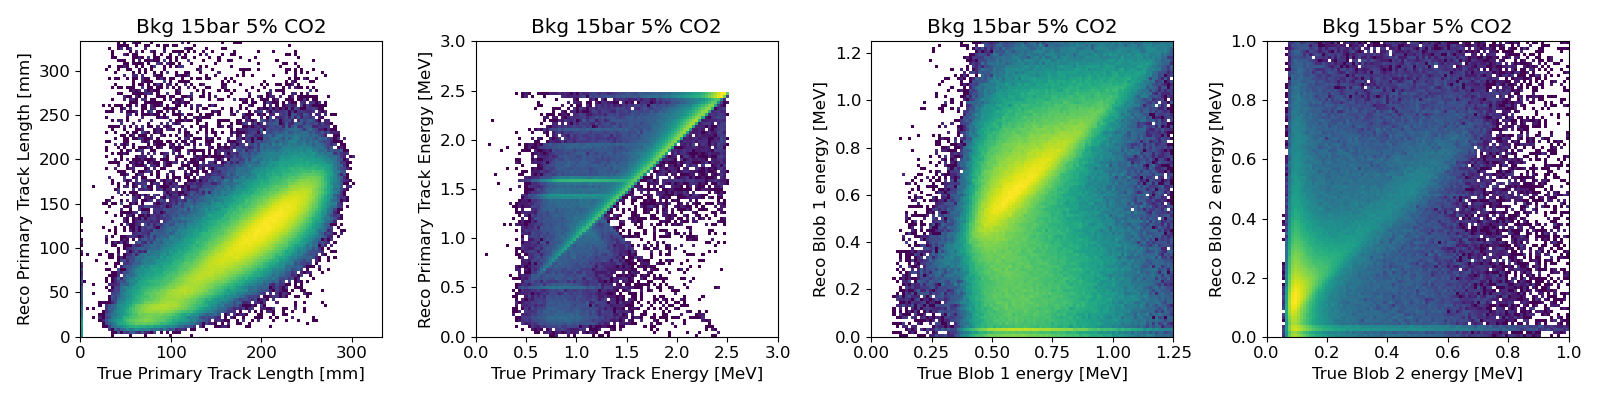

In [46]:

if (ApplyCutsb == False):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true, nubb_meta_1bar,   "0nubb", 1, diff)
    plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/TrueReco1barSignal.pdf")
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true, Bkg_meta_1bar,   "Bkg", 1, diff)
    plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/TrueReco1barBackground.pdf")


    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true, nubb_meta_5bar,   "0nubb", 5, diff)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true, Bkg_meta_5bar,   "Bkg", 5, diff)


    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true, nubb_meta_10bar,  "0nubb", 10, diff)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true, Bkg_meta_10bar,  "Bkg", 10, diff)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true, nubb_meta_15bar,  "0nubb", 15, diff)
    plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/TrueReco15barSignal.pdf")
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true, Bkg_meta_15bar,  "Bkg", 15, diff)
    plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/TrueReco15barBackground.pdf")
else:
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true_1bar, nubb_meta_1bar,   "0nubb", 1, diff)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true_1bar, Bkg_meta_1bar,   "Bkg", 1, diff)


    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true_5bar, nubb_meta_5bar,   "0nubb", 5, diff)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true_5bar, Bkg_meta_5bar,   "Bkg", 5, diff)


    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true_10bar, nubb_meta_10bar,  "0nubb", 10, diff)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true_10bar, Bkg_meta_10bar,  "Bkg", 10, diff)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true_15bar, nubb_meta_15bar,  "0nubb", 15, diff)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true_15bar, Bkg_meta_15bar,  "Bkg", 15, diff)




In [41]:
def PlotResolutions(df_true, df_reco, col, title, label, pressure, diff):

    uselog = False

    df_true = df_true[df_true.pressure == pressure]
    df_reco = df_reco[df_reco.primary == 1]

    # Ensure the reco and true have the same events
    df_true = df_true[df_true.event_id.isin(df_reco.event_id.unique())]
    df_reco = df_reco[df_reco.event_id.isin(df_true.event_id.unique())]

    df = pd.merge(df_true, df_reco, on='event_id', how='inner')

    res = ((df.length - df.TrackLength) / df.TrackLength).dropna()
    axs[0].hist(res, bins = np.linspace(-1,1,100),histtype="step", color = col, label = label)
    axs[0].set_xlabel("Primary Track Length Resolution")
    axs[0].set_ylabel("Entries")
    axs[0].legend()
    axs[0].set_title(f"{title} {diff}")
    if (uselog): axs[0].semilogy()

    res = ((df.energy - df.TrackEnergy) / df.TrackEnergy).dropna()
    axs[1].hist(res, bins = np.linspace(-1,1,100), histtype="step", color = col, label = label);
    axs[1].set_xlabel("Primary Track Energy Resolution")
    axs[1].set_ylabel("Entries")
    axs[1].legend()
    axs[1].set_title(f"{title} {diff}")
    if (uselog): axs[1].semilogy()

    res = ((df.blob1R - df.Blob1E) / df.Blob1E).dropna()
    axs[2].hist(res, bins = np.linspace(-1,1,100), histtype="step", color = col, label = label);
    axs[2].set_xlabel("Blob 1 energy Resolution")
    axs[2].set_ylabel("Entries")
    axs[2].legend()
    axs[2].set_title(f"{title} {diff}")
    if (uselog): axs[2].semilogy()

    res = ((df.blob2R - df.Blob2E) / df.Blob2E).dropna()
    axs[3].hist(res, bins = np.linspace(-1, 1, 100), histtype="step", color = col, label = label);
    axs[3].set_xlabel("Blob 2 energy Resolution")
    axs[3].set_ylabel("Entries")
    axs[3].legend()
    axs[3].set_title(f"{title} {diff}")
    if (uselog): axs[3].semilogy()

    plt.tight_layout()

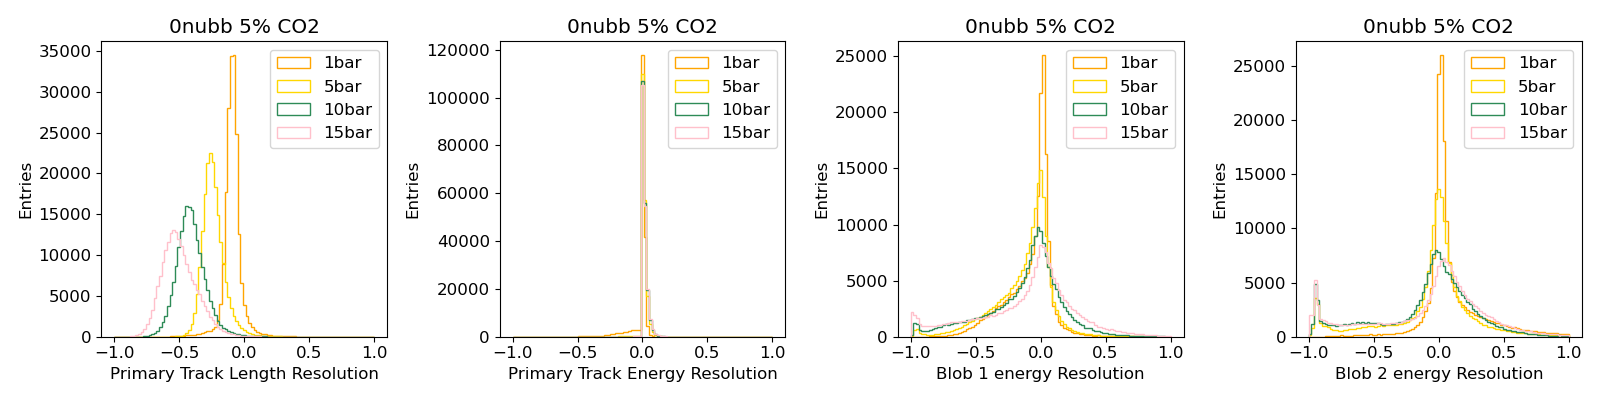

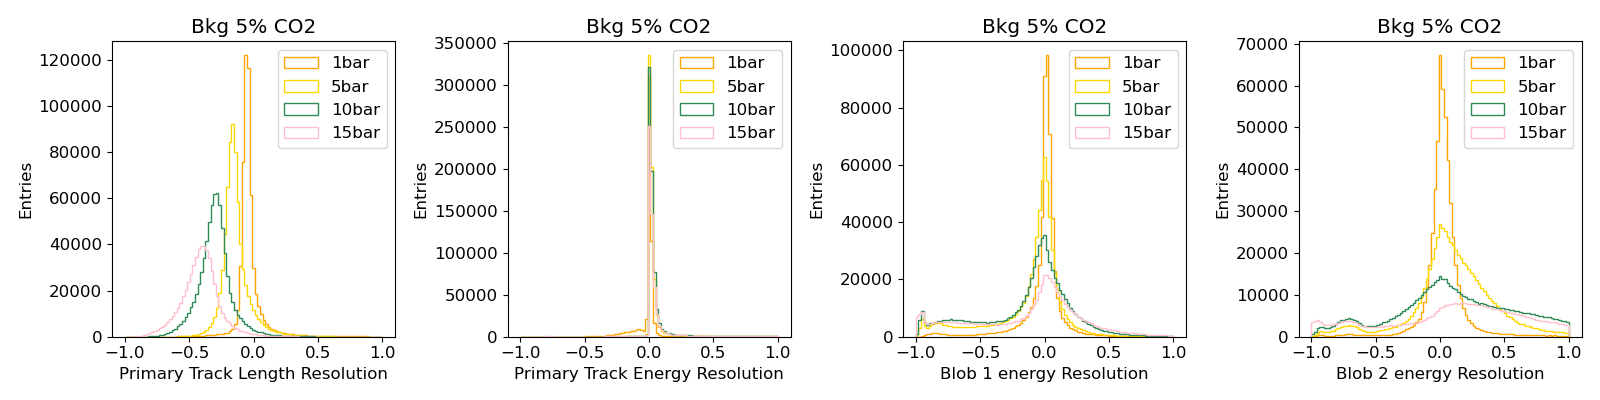

In [43]:

if (ApplyCutsb == False):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    PlotResolutions(nubb_nexus_true, nubb_meta_1bar, "orange",   "0nubb", "1bar",  1, diff)
    PlotResolutions(nubb_nexus_true, nubb_meta_5bar, "gold",     "0nubb", "5bar",  5, diff)
    PlotResolutions(nubb_nexus_true, nubb_meta_10bar, "seagreen", "0nubb", "10bar", 10, diff)
    PlotResolutions(nubb_nexus_true, nubb_meta_15bar, "Pink",     "0nubb", "15bar", 15, diff)
    plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/ResolutionsSignal.pdf")


    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    PlotResolutions(Bkg_nexus_true, Bkg_meta_1bar,  "orange",   "Bkg", "1bar",  1, diff)
    PlotResolutions(Bkg_nexus_true, Bkg_meta_5bar,  "gold",     "Bkg", "5bar",  5, diff)
    PlotResolutions(Bkg_nexus_true, Bkg_meta_10bar, "seagreen", "Bkg", "10bar", 10, diff)
    PlotResolutions(Bkg_nexus_true, Bkg_meta_15bar, "Pink",     "Bkg", "15bar", 15, diff)
    plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/ResolutionsBackground.pdf")

else:
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    PlotResolutions(nubb_nexus_true_1bar, nubb_meta_1bar, "orange",   "0nubb 1bar",  1, diff)
    PlotResolutions(nubb_nexus_true_5bar, nubb_meta_5bar, "gold",     "0nubb 5bar",  5, diff)
    PlotResolutions(nubb_nexus_true_10bar, nubb_meta_10bar, "seagreen", "0nubb 10bar", 10, diff)
    PlotResolutions(nubb_nexus_true_15bar, nubb_meta_15bar, "Pink",     "0nubb 15bar", 15, diff)


    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    PlotResolutions(Bkg_nexus_true_1bar, Bkg_meta_1bar,  "orange",   "Bkg 1bar",  1, diff)
    PlotResolutions(Bkg_nexus_true_5bar, Bkg_meta_5bar,  "gold",     "Bkg 5bar",  5, diff)
    PlotResolutions(Bkg_nexus_true_10bar, Bkg_meta_10bar, "seagreen", "Bkg 10bar", 10, diff)
    PlotResolutions(Bkg_nexus_true_15bar, Bkg_meta_15bar, "Pink",     "Bkg 15bar", 15, diff)

In [33]:
display(Bi_nexus_true[Bi_nexus_true.pressure == 15])
print(len(Bi_nexus_true[Bi_nexus_true.pressure == 15].event_id.unique()))

,event_id,TrackLength,TrackEnergy,TrackEnergy1,TrackEnergy2,TrackEnergy3,Blob1E,Blob2E,TrackDiam,CreatorProc,pressure
0,640001,74.385056,0.979179,0.859941,0.979179,0.979179,0.638832,0.110688,28.500364,compt,15
1,640002,162.592316,2.056548,1.692875,1.692875,2.056548,0.405613,0.155270,76.080055,phot,15
2,640004,122.260849,1.472359,1.224715,1.472359,1.472359,0.539949,0.103908,42.396015,compt,15
3,640005,114.890747,1.319102,1.319102,1.319102,1.319102,0.705837,0.264880,50.136009,phot,15
4,640009,83.925034,1.080372,1.080372,1.080372,1.080372,0.665212,0.095367,37.940220,compt,15
...,...,...,...,...,...,...,...,...,...,...,...
119,640000201,184.629150,1.828232,1.828232,1.828232,1.828232,0.611649,0.097067,83.047020,compt,15
120,640000202,108.848679,1.120272,1.120272,1.120272,1.120272,0.577938,0.101874,40.309155,compt,15
121,640000205,145.443909,1.558732,1.558732,1.558732,1.558732,0.566054,0.111362,49.937656,compt,15
122,640000206,90.848244,1.518735,1.016354,1.016354,1.016354,0.482221,0.156281,38.088711,compt,15


229621
